<a href="https://colab.research.google.com/github/adambouras/OHDSI-Symposium-Submission/blob/main/OHDSI_Submission_BERT_Similarity_Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this project is to assess the similarities and differences that exits between assessment tools and questions for food insecurity that were identified by the Gravity Project (GP). These questions are divided into two groups; one group that has been used as <a href="https://www.hl7.org/fhir/" target="_blank">FHIR resources</a> and mapped to OMOP CDM **(Group A)**. The other group of questions are identified by the GP but **NOT** mapped to OMOP CDM nor identified as FHIR resources **(Group B)**. This project will help identify the level of difference and substitutability that may exit between Group A and Group B.

In [1]:
%%capture
%pip install -r requirement.txt

In [1]:
%%capture

import pandas as pd
import os
import types
import numpy as np
import re
from bertopic import *
from pyxlsb import open_workbook
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
import plotly.express as px
import plotly.graph_objects as go
import pip
from pyxlsb import open_workbook
import pandas as pd
import os
import types
import numpy as np
import re
from bertopic import BERTopic


In [2]:
%%capture
import session_info
session_info.show()

In [5]:
# Dataframe styling
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': 'background-color: #ffffb3'
    }
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #b30000; color: white; text-align: center'
}
cell_align = {
        'selector': 'td',
        'props': 'text-align: left'
              }

For this project, I used the [Hugging Face](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) open source BERT Model to construct and build the algorithm. The model provides sentence similarity by mapping sentences and paragraphs to a 384 dimensional dense vector space and that can be used for tasks like clustering or sementic search. The training data set contains a total number of sentence pairs above 1 billion sentences. 
![Algorithm used to identify the questions similarities](./img/OHDSI-BERT%20Ranking.jpg)

We started our project by reading the excel file from the github repo. the orginal [excel file](https://confluence.hl7.org/download/attachments/91994432/05142021%20Food%20Insecurity%20MASTER.xlsx?api=v2) was dwonloaded from [GP website](https://confluence.hl7.org/display/GRAV/Food+Insecurity). We conduct manual mapping of the assessment tool questions to [OMOP CDM using Athena](https://athena.ohdsi.org/search-terms/start). We created additional columns to report whether the questions [LOINC Codes](https://loinc.org/get-started/what-loinc-is/) was mapped or not. The final [excel file](08.31.2023%20Food%20Insecurity%20Screening%20SDOH%20Gravity%20Project.xlsx) is included in the github repostory of this project.

In [6]:
xls = pd.ExcelFile("https://github.com/adambouras/OHDSI-Symposium-Submission/raw/main/08.31.2023%20Food%20Insecurity%20Screening%20SDOH%20Gravity%20Project.xlsx")

In [153]:
%%capture
xls.sheet_names

In [8]:
#create dictionary for later retrieval
d_s = {'sheet':[], 'df': []}
for i , c in enumerate(xls.sheet_names, 1):
    globals()['df'+ str(i)] = pd.read_excel(xls, c)
    d_s['sheet'].append(c+str(i))
    d_s['df'].append('df'+str(i))

<h2>Create analysis of topics embedding</h2>
<p>Before we start creating topics embeddings, we will first conduct some text analysis by standardizing the text and remove redundant text as showing in the cell below.</p>
<h3>Description of Food Program</h3>
<p>GP identified 23 programs and they are displayed in below.</p>

In [10]:

df1.style.set_table_styles([ cell_align, cell_hover, index_names, headers])


,Program,Definition,"Includes, but is not limited to"
0,Benefit Enrollement Assistance Program,"A program that coordinates cross sector benefit eligibility, assessment and application",nan
1,Child and adult care food program (CFCAP),"A government program that provides CACFP reimbursements for nutritious meals and snacks to eligible children and adults who are enrolled for care at participating child care centers, day care homes, and adult day care centers. The program also provides reimbursements for meals served to children and youth participating in afterschool care programs, children residing in emergency shelters, and older adults or living with a disability and enrolled in day care facilities. https://www.fns.usda.gov/cacfp/child-and-adult-care-food-program",nan
2,Community Action Agency,Non-profit private and public organizations established under the Economic Opportunity Act of 1964 with the aim of helping people achieve self-sufficiency. https://www.hud.gov/states/california/homeless/commaction,nan
3,Community meal program,Meals for a target group.,Congregate meals
4,Community Resource Assistance,Help connecting individuals with available community resources to address identified social needs,nan
5,Food and nutrition incentive program,Financial incentives or matching programs to promote consumption of healthful foods including produce via community supported agriculture and other initiatives.,Gus Schumacher Nutrition Incentive program Senior farmers market
6,Food Distribution Program on Indian Reservation (FDPIR),Provides USDA Foods to income-eligible households living on Indian reservations and to Native American households residing in designated areas near reservations or in Oklahoma. USDA distributes both food and administrative funds to participating Indian Tribal Organizations and state agencies to operate FDPIR.,nan
7,Food pantry program,"A community based supportive food and nutrition program offering food to individuals for consumption. https://www.feedingamerica.org/our-work/food-bank-network, https://www.fns.usda.gov/fdpir/food-distribution-program-indian-reservations",FDIPR (Food Distribution Program on Indian Reservation) School based pantry
8,Food prescription program,"Prescription from a health care provider to access foods recommended, which also includes vegetables, fruits, and prescriptions for other foods.",Food Prescription Produce Prescription Veggie Prescription
9,Food provision program,"Food offered when a support need is identified. Examples include groceries as part of an education opportunity (e.g., cooking class), commodity food program, food rescue or gleaning program (e.g., produce brought to a clinic), or weekend food backpack program.",nan


<h3>Distribution of number of question by screen tools</h3>
<p>The GP identified 24 screen tools and some of the tools are nested tools from other tools for the simplicity of this analysis, we will not consolidate these nested tools into a single tool. By doing so, we will help the community to identify the best approaches to make this tools standarized and consolidated for easy retrieval and use.</p>

In [11]:
# screen_tool_summary = df3.groupby('Relevant_Screening_Tool')['LOINC_Panel_Code'].nunique()
df_scr_tool_sum = df3.groupby(by=['Relevant_Screening_Tool', 'Mapped_to_Athena'], dropna=False, as_index=False).agg({'LOINC_Panel_Code': pd.Series.nunique}).sort_values('LOINC_Panel_Code')

In [12]:
df_scr_tool_sum['Mapped_to_Athena'] = df_scr_tool_sum['Mapped_to_Athena'].fillna('No')
df_scr_tool_sum.sort_values(by=['Mapped_to_Athena', 'LOINC_Panel_Code'], ascending=False, inplace=True)
df_scr_tool_sum.rename(columns={'Relevant_Screening_Tool':'Screening Tool','LOINC_Panel_Code':'LOINC Code', 'Mapped_to_Athena':'Mapped to Athena'}, inplace=False).style.set_table_styles([ cell_align, cell_hover, index_names, headers])

,Screening Tool,Mapped to Athena,LOINC Code
1,AHC,Yes,2
15,PRAPARE,Yes,1
9,Hunger Vital Sign,Yes,1
8,Household Food Security Survey Module (HFSSM) (NOTE: Canadian survey adapted from the US food security measurement method),No,19
5,HFIAS,No,19
22,USDA Youth,No,9
4,FIES-SM,No,8
19,US household food security 18 item,No,8
21,US household food security ten item US household food security 18 item,No,5
20,US household food security six item US household food security ten item US household food security 18 item,No,4


<p>The graph below provides the number of questions by screen tool grouped into those questions that we were able to map to **Athena**.</p>

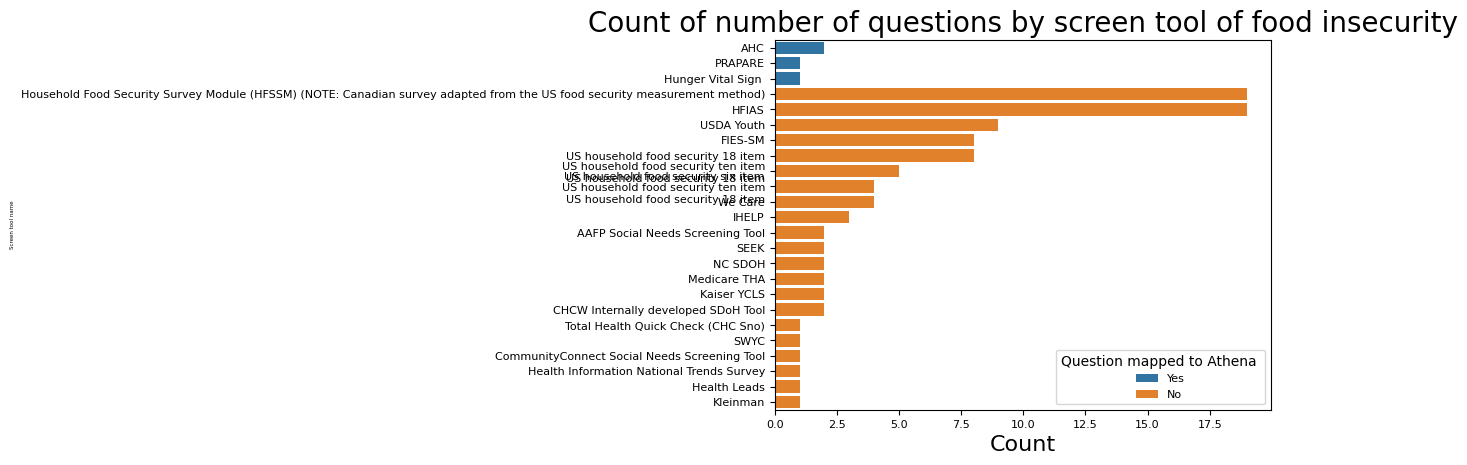

In [13]:
import matplotlib.pyplot as plt

sns.barplot(df_scr_tool_sum, x= 'LOINC_Panel_Code', y= 'Relevant_Screening_Tool', orient="y", hue='Mapped_to_Athena')
#modify individual font size of elements
plt.legend(title='Question mapped to Athena ', fontsize=8)
plt.xlabel('Count', fontsize=16);
plt.ylabel('Screen tool name', fontsize=4);
plt.title('Count of number of questions by screen tool of food insecurity', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=8)

In [14]:
import re
#select questions that have mapped to athena
sentences_yes = df3['Question_Concept'].loc[df3['Mapped_to_Athena'] == 'Yes'].unique().tolist()
sentences_yes = [x for x in sentences_yes if str(x) != 'nan']
#remove redundant words
pattern_yes = r"\s+\[U\.S\. FSS\]"
sentences_yes = [re.sub(pattern_yes, '', str(x)) for x in sentences_yes]
#select unique assessment questions:
duplicate_question = 'Within the past 12 months we worried whether our food would run out before we got money to buy more'
sentences_yes.remove(duplicate_question)
#select questions that were not mapped to any vocabularly using Athena:
sentences_no = df3['Question_Concept'].loc[df3['Mapped_to_Athena'] != 'Yes'].unique().tolist()
#clean string from unecessary strings Q1 Q14b. etc....
pattern = r"Q\d{1,2}\.\s+|Q\d{1,2}b\.\s+|\?|\."
sentences_no = [re.sub(pattern, '', str(x)) for x in sentences_no]
#Delete question mapped to Athena but not reported by the gravity team
duplicated_question  = 'Within the past 12 months, you worried that your food would run out before you got money to buy more'
sentences_no.remove(duplicated_question)
sentences = [sentences_yes, sentences_no]

In [15]:
%%capture
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

In [27]:
%%capture
model = SentenceTransformer('all-MiniLM-L6-v2')

#Compute bi-ranked embedding for food insecurity

ranked_domain ={'standard': [] ,'index_yes':[], 'index_no':[], 'label_yes': [], 'label_no':[], 'ranked_value':[]}
for h,s in enumerate(sentences):
  if h ==0: #select questions that have been mapped to Athena  for embedding
    embedding_1= model.encode(s, convert_to_tensor=True)
    for i, sentence in enumerate(sentences_no):
      embedding_2 = model.encode(sentence, convert_to_tensor=True)
      #Compute cosine-similarities
      cosine_scores = util.cos_sim(embedding_1, embedding_2)
      #Output the pairs with their score
      for j, sentence_yes in enumerate(sentences_yes):
        ranked_domain['standard'].append(h)
        ranked_domain['index_yes'].append(str(j))
        ranked_domain['index_no'].append(str(i))
        ranked_domain['label_yes'].append(sentence_yes)
        ranked_domain['label_no'].append(sentence)
        na = np.round(cosine_scores.numpy(),2)
        ranked_domain['ranked_value'].append(round(na[j][0],2))

In [33]:
df =pd.DataFrame.from_dict(ranked_domain)

In [34]:
df.head()


,standard,index_yes,index_no,label_yes,label_no,ranked_value
0,0,0,0,Within the past 12 months the food we bought j...,Do you eat fewer than 2 meals a day,0.38
1,0,1,0,"Within the past 12 months, you worried that yo...",Do you eat fewer than 2 meals a day,0.43
2,0,2,0,"Within the past 12 months, the food you bought...",Do you eat fewer than 2 meals a day,0.35
3,0,3,0,"In the past year, have you or any family membe...",Do you eat fewer than 2 meals a day,0.04
4,0,0,1,Within the past 12 months the food we bought j...,Do you always have enough money to buy the foo...,0.64


<h2>Text Similarity Score</h2>
<p>The interactive appplication below provide the capbility to select the text similarity score and thus broading or narrow the semantic similarity between the questions mapped to the OMOP CDM and those that were not mapped.</p>

In [152]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, HTML
import plotly.graph_objects as go
import panel as pn
pn.extension()


# interact(slow_function,i=FloatSlider(min=1e5, max=1e7, step=1e5, continuous_update=False));
# @interact(x=(-1, 1, .01))

#get the min and max values of the df data:

baseline = widgets.FloatRangeSlider(
    value=[0.2, 0.6],
    min=-1.0,
    max=1.0,
    step=0.1,
    description='Similarity score:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    style = {"description_width": "initial"}
)

text = df['index_no'].astype(str).unique().tolist()

widgets.HBox([baseline])

#create an initial plot object:
df_map = df.pivot(index= 'index_no', columns='index_yes',  values='ranked_value')
trace1 = go.Heatmap(z=df_map.values,
                   x=df['index_yes'].astype(str).unique().tolist(),
                   y=df['index_no'].astype(str).unique().tolist(),
                   hoverongaps = False)
#get the column names:
l = df.columns.tolist()
trace2 = go.Table(
    header=dict(values=list(l),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df[col] for col in l],
               fill_color='lavender',
               align='left'))
fig1 = go.Figure(data=[trace1])

fig2 =go.Figure(data=[trace2])
for f in [fig1,fig2]:
    f.update_layout(
        width = 1000,
        height = 1500,
        yaxis=dict(ticktext = text, tickmode="array", type="category"),
        margin=dict(l=5, r=5, t=5, b=5))

f1 = go.FigureWidget(fig1)
f2 = go.FigureWidget(fig2)

def validate():
    if baseline.value in df['ranked_value'].unique():
        return True
    else:
        return False

def response(change):
    try:
        if min(baseline.value) >=0:
            df_n = df.loc[(min(baseline.value) <= df['ranked_value']) & (df['ranked_value'] <= max(baseline.value))].sort_values(by='ranked_value', ascending=False)
        elif min(baseline.value)<0:
           df_n = df.loc[(min(baseline.value) <= df['ranked_value']) & (df['ranked_value'] <= max(baseline.value))].sort_values(by='ranked_value', ascending=True) 
        x1 = df_n.pivot(index= 'index_no', columns='index_yes',  values='ranked_value')

        df_n_dict = dict.fromkeys(df_n.columns, '')

        with f1.batch_update():
            f1.data[0].z = x1
        with f2.batch_update():
            f2.data[0].header.values = list(df_n_dict) 
            f2.data[0].cells.values = [df_n[col] for col in df_n_dict]
    except:
        print('error')


baseline.observe(response, names="value")
visual_container = widgets.VBox([f1,f2])
display(widgets.VBox([baseline, visual_container]))
display(HTML('<style> .widget-text { width: auto; } </style>'))

HTML(value='<style> .widget-text { width: auto; } </style>')